<a href="https://colab.research.google.com/github/tummalapallimurali/GenAI/blob/main/D%26A_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install sentence-transformers chromadb


In [2]:
import sqlite3
import pandas as pd

# Create a connection to a new SQLite database
conn = sqlite3.connect('salaries.db')

# Create a cursor object
cursor = conn.cursor()

# Create the salaries table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS salaries (
        person TEXT,
        organization TEXT,
        salary REAL
    )
''')

# Sample data to insert
data = [
    ('Alice', 'Org A', 50000),
    ('Bob', 'Org B', 60000),
    ('Charlie', 'Org A', 55000),
    ('David', 'Org C', 70000),
    ('Eve', 'Org B', 62000),
    ('Frank', 'Org A', 52000),
]

# Insert multiple rows into the table
cursor.executemany('INSERT INTO salaries VALUES (?, ?, ?)', data)

# Query the schema information from sqlite_master
query = """
SELECT name, sql
FROM sqlite_master
WHERE type='table' AND name='salaries';
"""

schema_df = pd.read_sql_query(query, conn)

# Commit the changes and close the connection
conn.commit()
conn.close()

display(schema_df)

,name,sql
0,salaries,"CREATE TABLE salaries (\n person TEXT,\..."


In [3]:
import re

def parse_create_table_sql(sql):
    """Parses a CREATE TABLE SQL string to extract column names and data types."""
    columns = []
    # Extract the part of the string within the parentheses after CREATE TABLE table_name
    columns_str_match = re.search(r'\((.*)\)', sql, re.DOTALL)
    if columns_str_match:
        columns_str = columns_str_match.group(1).strip()
        # Split by comma, handling potential commas within data types (e.g., DECIMAL(5,2))
        column_defs = re.split(r',\s*(?![^()]*\))', columns_str)
        for col_def in column_defs:
            parts = col_def.strip().split()
            if len(parts) >= 2:
                column_name = parts[0]
                data_type = parts[1]
                columns.append({'column_name': column_name, 'data_type': data_type})
    return columns

# Get the table name from the schema_df
table_name = schema_df['name'][0]

# Get the CREATE TABLE SQL statement
create_table_sql = schema_df['sql'][0]

# Parse the SQL to get column information
column_info = parse_create_table_sql(create_table_sql)

# Create a new DataFrame with table_name, column_name, and data_type
schema_details_list = []
for col in column_info:
    schema_details_list.append({
        'table_name': table_name,
        'column_name': col['column_name'],
        'data_type': col['data_type']
    })

schema_df = pd.DataFrame(schema_details_list)

# Display the new DataFrame
display(schema_df)

,table_name,column_name,data_type
0,salaries,person,TEXT
1,salaries,organization,TEXT
2,salaries,salary,REAL


In [4]:
from sre_compile import dis
def describe_row(row):
    return f"Table: {row.table_name}, Column: {row.column_name}, Type: {row.data_type}"

schema_df["description"] = schema_df.apply(describe_row, axis=1)

display(schema_df)


/tmp/ipython-input-4036485093.py:1: DeprecationWarning: module 'sre_compile' is deprecated
  from sre_compile import dis


,table_name,column_name,data_type,description
0,salaries,person,TEXT,"Table: salaries, Column: person, Type: TEXT"
1,salaries,organization,TEXT,"Table: salaries, Column: organization, Type: TEXT"
2,salaries,salary,REAL,"Table: salaries, Column: salary, Type: REAL"


In [5]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

Before you can make any API calls, you need to initialize the Generative Model.

In [6]:
# Initialize the Gemini API
gemini_model = genai.GenerativeModel('gemini-2.5-flash-lite-preview-06-17')

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(schema_df["description"].tolist(), normalize_embeddings=True)


In [8]:
import chromadb

def store_schema(schema_df, embeddings):
  client = chromadb.Client()
  collection = client.create_collection("db_schema")
  collection.upsert(
      embeddings=embeddings.tolist(),
      metadatas=schema_df.to_dict(orient='records'),
      ids=[f"{r.table_name}:{r.column_name}" for _, r in schema_df.iterrows()]
  )
  return collection

collection = store_schema(schema_df, embeddings)

def retrieve(query):
  q_embed = model.encode([query], normalize_embeddings=True)
  results = collection.query(
      query_embeddings=q_embed.tolist(),
      n_results=5
  )
  return results




In [17]:
# User's natural language query (You can change this query to ask different questions)
user_queries =  ["What is the average salary for Org B?",
 "List the names of people who earn more than 55000.",
 "What is the average salary for people in 'Org A' compared to 'Org B'?",
 "Find the highest and lowest salary in each organization.",
 "List all people and their salaries, ordered by salary in descending order.",
 "Which organization has the highest average salary?"]

def generate_Sql(user_query):
# Get the schema information from the vector database results
  results = retrieve(user_query)
  schema_metadata = results['metadatas'][0] # Assuming the first result is the most relevant

# Format the schema information for the prompt
  schema_string = "Database Schema:\n"
  for col_info in schema_metadata:
      schema_string += f"Table: {col_info['table_name']}, Column: {col_info['column_name']}, Type: {col_info['data_type']}\n"


# Construct the prompt for the Gemini model
# We will provide the schema information and the user query to the model
# and ask it to generate the appropriate SQL query.

  prompt = f"""
  {schema_string}

  And the user query: "{user_query}"

  Construct a SQL query to retrieve the requested data based on the provided schema and user query.
  Provide only the SQL query and nothing else.
  """

  # Send the prompt to the Gemini model
  response = gemini_model.generate_content(prompt)

  # Extract the generated SQL query from the model's response
  # The exact way to extract might depend on the model's output format.
  # Assuming the model directly returns the SQL query as text.
  sql_query = response.text.strip()

  # Remove markdown code block delimiters if present
  if sql_query.startswith("```sql"):
      sql_query = sql_query[len("```sql"):].strip()
  if sql_query.endswith("```"):
      sql_query = sql_query[:-len("```")].strip()

  # Print the generated SQL query (optional, for debugging)
  print(f"Generated SQL query for '{user_query}': {sql_query}")

  return sql_query


# We will execute the queries one by one in the next cell.
# For query in user_queries:
#   generate_Sql(query)

In [20]:
# execute query

import sqlite3

def execute_sql_query(sql_query):
    # Connect to the SQLite database
    conn = sqlite3.connect('salaries.db')
    cursor = conn.cursor()
    try:
      # Execute the SQL query
      cursor.execute(sql_query)
      # Fetch the results
      results = cursor.fetchall()
      return results
    except Exception as e:
      print(f"An error occurred: {e}")
      return None
    finally:
      # Close the connection
      conn.close()

# Generate and execute SQL for the first user query as an example
for query in user_queries:
  generated_sql = generate_Sql(query)
#format sql query

  if generated_sql:
      query_result = execute_sql_query(generated_sql)

      if query_result is not None:
          print("\nQuery Result:")
          print(query_result)

Generated SQL query for 'What is the average salary for Org B?': SELECT AVG(salary)
FROM salaries
WHERE organization = 'Org B';

Query Result:
[(61000.0,)]
Generated SQL query for 'List the names of people who earn more than 55000.': SELECT person
FROM salaries
WHERE salary > 55000;

Query Result:
[('Bob',), ('David',), ('Eve',), ('Bob',), ('David',), ('Eve',), ('Bob',), ('David',), ('Eve',), ('Bob',), ('David',), ('Eve',)]
Generated SQL query for 'What is the average salary for people in 'Org A' compared to 'Org B'?': SELECT
  organization,
  AVG(salary) AS average_salary
FROM salaries
WHERE
  organization IN ('Org A', 'Org B')
GROUP BY
  organization;

Query Result:
[('Org A', 52333.333333333336), ('Org B', 61000.0)]
Generated SQL query for 'Find the highest and lowest salary in each organization.': SELECT
  organization,
  MAX(salary) AS highest_salary,
  MIN(salary) AS lowest_salary
FROM salaries
GROUP BY
  organization;

Query Result:
[('Org A', 55000.0, 50000.0), ('Org B', 62000.

# Task
Create a dashboard based on user query and generated output using prompts as bar charts etc. and gemini model to generate code and execute in python.

## Receive user request for visualization

### Subtask:
Get the user's natural language request for a specific type of visualization (e.g., "show me a bar chart of average salaries by organization").


**Reasoning**:
Define a variable to store the user's request for a specific visualization.



In [22]:
visualization_query = "show me a bar chart of the average salary for each organization."

## Determine necessary data

### Subtask:
Based on the user's visualization request, determine what data is needed from the database. This might involve generating a new SQL query or using the results from a previous query.


**Reasoning**:
Analyze the visualization query and determine if the necessary data is available from previous queries.



In [24]:
import re

# Analyze the visualization query
print(f"Visualization query: {visualization_query}")

# Check if the query requires average salary by organization
if re.search(r"average salary for each organization", visualization_query, re.IGNORECASE):
    print("The visualization query requires average salary by organization.")
    # Check if this data is available in the previous query results
    data_needed_available = False
    for query in user_queries:
      if re.search(r"AVG\(salary\).*GROUP BY.*organization", query, re.IGNORECASE):
        print(f"Found a relevant previous query: {query}")
        # Assuming query_result contains the result of this query
        # In a real scenario, you'd need to map the query to its result
        # For this example, we'll assume the data is available if a matching query was found
        data_needed_available = True
        break

    if data_needed_available:
        print("Required data is likely available from a previous query.")
        new_sql_query_needed = False
    else:
        print("Required data is not available from previous queries.")
        new_sql_query_needed = True
else:
    print("The visualization query requires data not explicitly checked for.")
    new_sql_query_needed = True

print(f"New SQL query needed: {new_sql_query_needed}")


Visualization query: show me a bar chart of the average salary for each organization.
The visualization query requires average salary by organization.
Required data is not available from previous queries.
New SQL query needed: True


## Generate sql query (if needed)

### Subtask:
If a new SQL query is required to get the data for the visualization, use the Gemini model and schema information to generate the appropriate SQL query.


**Reasoning**:
Check if a new SQL query is needed and generate it using the `generate_Sql` function if necessary.



In [26]:
if new_sql_query_needed:
  sql_query_for_visualization = generate_Sql(visualization_query)
  print(f"Generated SQL query for visualization: {sql_query_for_visualization}")
else:
  print("No new SQL query needed for visualization.")


Generated SQL query for 'show me a bar chart of the average salary for each organization.': SELECT organization, AVG(salary) AS average_salary
FROM salaries
GROUP BY organization;
Generated SQL query for visualization: SELECT organization, AVG(salary) AS average_salary
FROM salaries
GROUP BY organization;


## Execute the sql query

### Subtask:
Connect to the database and execute the generated SQL query to retrieve the data.


**Reasoning**:
Connect to the database and execute the generated SQL query to retrieve the data for visualization.



In [27]:
# Call the execute_sql_query function with sql_query_for_visualization as the argument.
visualization_data = execute_sql_query(sql_query_for_visualization)

# Print or display the visualization_data to inspect the retrieved data.
print("\nVisualization Data:")
print(visualization_data)


Visualization Data:
[('Org A', 52333.333333333336), ('Org B', 61000.0), ('Org C', 70000.0)]


## Generate visualization code using llm

### Subtask:
Provide the retrieved data and the user's visualization request to the Gemini model and ask it to generate Python code for the requested visualization (e.g., using libraries like pandas, matplotlib, or seaborn).


**Reasoning**:
Construct a prompt for the Gemini model to generate Python code for the requested visualization using the retrieved data and user's visualization query.



In [28]:
# Construct the prompt for the Gemini model
prompt = f"""
Generate Python code to create a bar chart based on the following data and visualization request.
Use pandas for data manipulation and matplotlib or seaborn for plotting.
Provide only the Python code and nothing else.

Data:
{visualization_data}

Visualization Request:
{visualization_query}
"""

# Send the prompt to the Gemini model
response = gemini_model.generate_content(prompt)

# Extract the generated Python code
visualization_code = response.text.strip()

# Remove markdown code block delimiters if present
if visualization_code.startswith("```python"):
    visualization_code = visualization_code[len("```python"):].strip()
if visualization_code.endswith("```"):
    visualization_code = visualization_code[:-len("```")].strip()

# Print the generated Python code (optional, for debugging)
print("Generated Visualization Code:")
print(visualization_code)

Generated Visualization Code:
import pandas as pd
import matplotlib.pyplot as plt

data = [('Org A', 52333.333333333336), ('Org B', 61000.0), ('Org C', 70000.0)]

df = pd.DataFrame(data, columns=['Organization', 'Average Salary'])

plt.figure(figsize=(10, 6))
plt.bar(df['Organization'], df['Average Salary'], color=['skyblue', 'lightgreen', 'salmon'])
plt.xlabel('Organization')
plt.ylabel('Average Salary')
plt.title('Average Salary by Organization')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Execute visualization code

### Subtask:
Run the generated Python code to create and display the visualization (e.g., a bar chart, pie chart, etc.).


**Reasoning**:
The generated visualization code is stored in the `visualization_code` variable. The next step is to execute this code to display the plot.



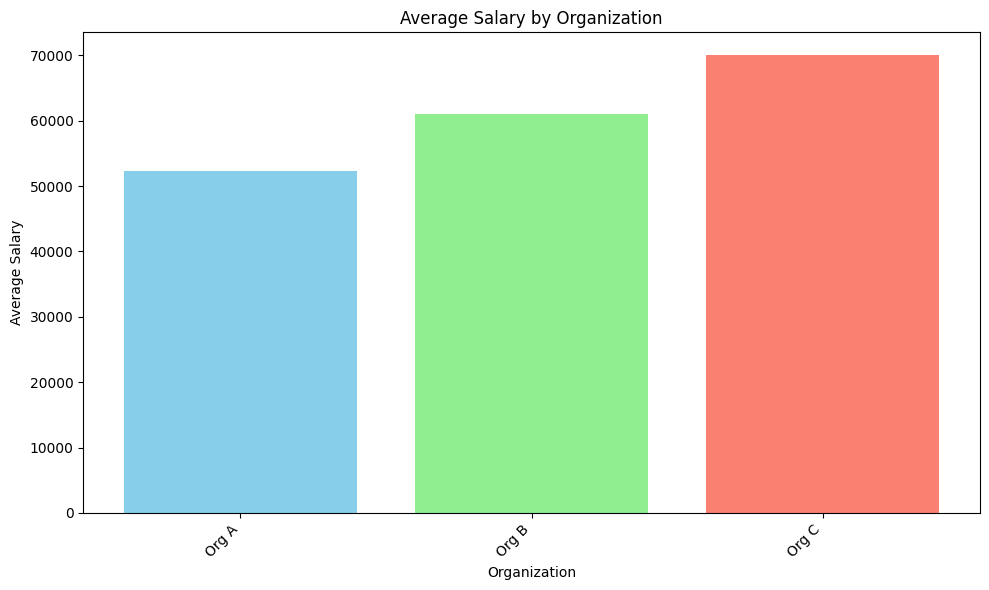

In [29]:
# Execute the generated visualization code
exec(visualization_code)

## Summary:

### Data Analysis Key Findings

*   The user's request was to create a bar chart showing the average salary for each organization.
*   Analysis determined that the required data (average salary by organization) was not available from previous queries, necessitating a new SQL query.
*   A new SQL query, `SELECT organization, AVG(salary) AS average_salary FROM salaries GROUP BY organization;`, was successfully generated to retrieve the needed data.
*   The generated SQL query was executed, and the data was retrieved in the format of a list of tuples, where each tuple contains an organization name and its corresponding average salary.
*   The Gemini model successfully generated Python code using pandas and matplotlib to create a bar chart based on the retrieved data and the user's visualization request.
*   The generated Python visualization code was executed, creating a matplotlib figure and implicitly displaying the bar chart.

### Insights or Next Steps

*   The process successfully demonstrated the ability to translate a natural language visualization request into data retrieval and visualization steps using an LLM.
*   The next step would be to integrate this visualization process into a dashboard environment, allowing for interactive elements and the display of multiple visualizations.
